**Experiment 2 - RoBERTa Tokenizer + Sequence Classifier (non - traditional machine learning model)**

In [1]:
# !pip install torch -U
# !pip install transformers[torch] accelerate -U scikit-learn

# **Model Configuration**

In [3]:
import torch
from transformers import RobertaTokenizerFast, RobertaForSequenceClassification, Trainer, TrainingArguments
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, roc_auc_score, roc_curve, auc
from google.colab import drive
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import seaborn as sns
import shutil

# Mount Google Drive
drive.mount('/content/drive')

# Load dataset from Google Drive
df = pd.read_csv('/content/drive/MyDrive/no_gpt.csv')

# Split dataset into training and validation sets
train_texts, val_texts, train_labels, val_labels = train_test_split(df['text'].tolist(), df['label'].tolist(), test_size=0.2)

# Tokenizer
tokenizer = RobertaTokenizerFast.from_pretrained("roberta-base")

# Tokenize the datasets
train_encodings = tokenizer(train_texts, truncation=True, padding=True)
val_encodings = tokenizer(val_texts, truncation=True, padding=True)

# Create PyTorch dataset
class HateSpeechDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

train_dataset = HateSpeechDataset(train_encodings, train_labels)
val_dataset = HateSpeechDataset(val_encodings, val_labels)

# Initialize the model
model = RobertaForSequenceClassification.from_pretrained("roberta-base", num_labels=2)

# Training arguments
training_args = TrainingArguments(
    output_dir='./results',          # output directory
    num_train_epochs=5,              # number of training epochs
    per_device_train_batch_size=16,  # batch size for training
    per_device_eval_batch_size=16,   # batch size for evaluation
    warmup_steps=500,                # number of warmup steps for learning rate scheduler
    weight_decay=0.01,               # strength of weight decay
    logging_dir='./logs',            # directory for storing logs
    logging_steps=10,
    eval_strategy="epoch",           # evaluation strategy to perform evaluation every epoch
    fp16=True,                       # use mixed precision training
    save_total_limit=1,              # limit the total amount of checkpoints, delete the older checkpoints
    save_strategy="epoch"            # save model every epoch
)

# Define compute metrics function
def compute_metrics(p):
    preds = p.predictions.argmax(-1)
    preds_probs = torch.nn.functional.softmax(torch.tensor(p.predictions), dim=-1)[:, 1]
    precision, recall, f1, _ = precision_recall_fscore_support(p.label_ids, preds, average='binary')
    acc = accuracy_score(p.label_ids, preds)
    roc_auc = roc_auc_score(p.label_ids, preds_probs)
    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall,
        'roc_auc': roc_auc
    }

# Initialize Trainer
trainer = Trainer(
    model=model,                         # the instantiated 🤗 Transformers model to be trained
    args=training_args,                  # training arguments, defined above
    train_dataset=train_dataset,         # training dataset
    eval_dataset=val_dataset,            # evaluation dataset
    compute_metrics=compute_metrics      # the function that computes metrics
)

# Train the model
trainer.train()

# Evaluate the model
eval_results = trainer.evaluate()

# Print evaluation results
print("Evaluation Results:", eval_results)

Mounted at /content/drive


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: official-jordanmarcelo (official-jordanmarcelo-sti-college-balagtas) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall,Roc Auc
1,0.496400,0.532856,0.749459,0.775755,0.698640,0.872007,0.818749
2,0.454000,0.493481,0.776287,0.789752,0.740939,0.845451,0.857074
3,0.551800,0.481652,0.779533,0.799607,0.729197,0.885067,0.869379
4,0.328700,0.527574,0.801385,0.813339,0.763068,0.870701,0.877319
5,0.236500,0.575463,0.805063,0.810675,0.783509,0.839791,0.876822


Evaluation Results: {'eval_loss': 0.5754625797271729, 'eval_accuracy': 0.805062743401125, 'eval_f1': 0.8106745114519857, 'eval_precision': 0.7835093419983753, 'eval_recall': 0.8397910317805833, 'eval_roc_auc': 0.8768217544155303, 'eval_runtime': 6.9249, 'eval_samples_per_second': 667.451, 'eval_steps_per_second': 41.734, 'epoch': 5.0}


# **ROC AUC PLOT curve & Model Visualization**

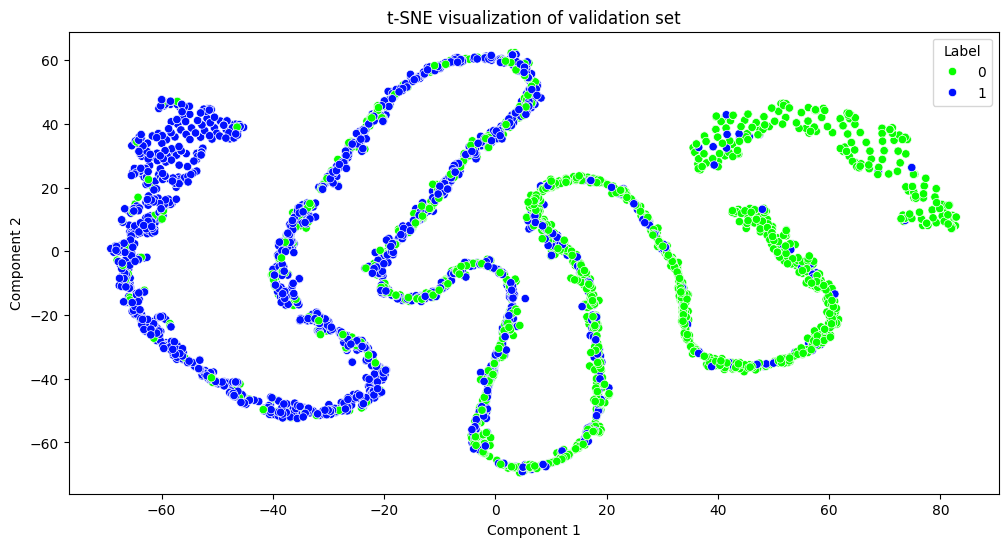

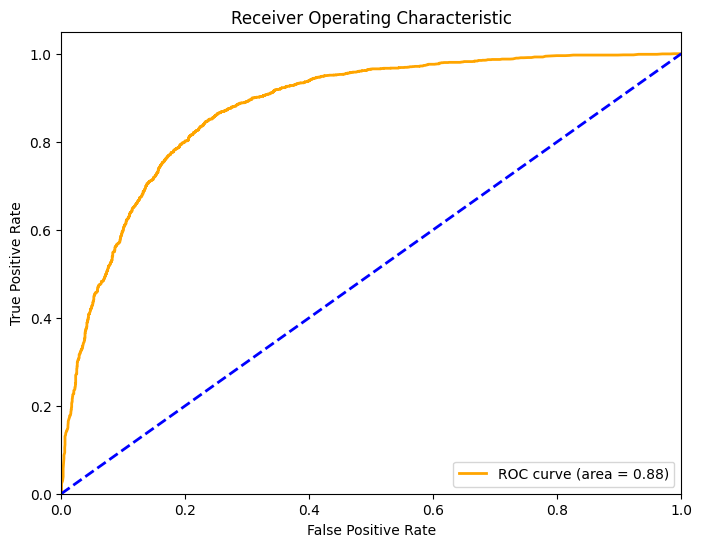

In [4]:
# t-SNE visualization function
def visualize_tsne(trainer, val_dataset, val_labels):
    # Get model predictions
    preds = trainer.predict(val_dataset).predictions
    # Apply t-SNE
    tsne = TSNE(n_components=2, random_state=42)
    tsne_results = tsne.fit_transform(preds)

    # Plot t-SNE
    plt.figure(figsize=(12, 6))
    sns.scatterplot(x=tsne_results[:, 0], y=tsne_results[:, 1], hue=val_labels, palette=sns.color_palette("hsv", 2))
    plt.title('t-SNE visualization of validation set')
    plt.xlabel('Component 1')
    plt.ylabel('Component 2')
    plt.legend(loc="best", title="Label")
    plt.show()

# ROC curve plotting function
def plot_roc_curve(trainer, val_dataset, val_labels):
    # Get model predictions
    preds = trainer.predict(val_dataset).predictions
    preds_probs = torch.nn.functional.softmax(torch.tensor(preds), dim=-1)[:, 1]

    # Compute ROC curve
    fpr, tpr, _ = roc_curve(val_labels, preds_probs)
    roc_auc = auc(fpr, tpr)

    # Plot ROC curve
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='orange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='blue', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()

# Visualize t-SNE and plot ROC curve
visualize_tsne(trainer, val_dataset, val_labels)
plot_roc_curve(trainer, val_dataset, val_labels)

# Save and download model to gdrive

# **Inference Time Test**

In [5]:
import os
import time
import numpy as np
import torch
from scipy import stats

# Ensure CUDA is available and set GPU
if torch.cuda.is_available():
    os.environ["CUDA_VISIBLE_DEVICES"] = "0"  # Set this to the desired GPU index
    device = torch.device("cuda")
    print(f"Using GPU: {torch.cuda.get_device_name(0)}")
else:
    device = torch.device("cpu")
    print("Using CPU.")

# Inference time measurement
test_sentence = "ito ay halimbawa ng isang pangungusap"
num_repeats = 5000

# Tokenize the test sentence
test_inputs = tokenizer(test_sentence, return_tensors="pt", truncation=True, padding=True)

# Move input tensors to the same device as the model
test_inputs = {key: value.to(device) for key, value in test_inputs.items()}

# Measure inference time
inference_times = []

for _ in range(num_repeats):
    start_time = time.time()
    with torch.no_grad():
        outputs = model(**test_inputs)
    end_time = time.time()
    inference_times.append(end_time - start_time)

# Convert to numpy array for convenience
inference_times = np.array(inference_times)

# Calculate mean and standard deviation
mean_time = np.mean(inference_times)
std_time = np.std(inference_times, ddof=1)  # Use ddof=1 for sample standard deviation

# Calculate the 95% confidence interval
confidence_level = 0.95
degrees_freedom = num_repeats - 1
confidence_interval = stats.t.interval(confidence_level, degrees_freedom, mean_time, std_time / np.sqrt(num_repeats))

print(f"Inference time for {num_repeats} repeats: {mean_time:.6f} seconds")
print(f"95% confidence interval: {confidence_interval[0]:.6f} to {confidence_interval[1]:.6f} seconds")


Using GPU: Tesla T4
Inference time for 5000 repeats: 0.012200 seconds
95% confidence interval: 0.012128 to 0.012272 seconds


In [ ]:
model_directory = "tl-hatespeech-model_directory"
model.save_pretrained(model_directory)
tokenizer.save_pretrained(model_directory)

# Zip the model directory
shutil.make_archive(model_directory, 'zip', model_directory)

# Define the path to your Google Drive
gdrive_path = '/content/drive/My Drive/'

# Copy the zipped model file to Google Drive
shutil.copy(f"{model_directory}.zip", gdrive_path)
print(f"Model uploaded to Google Drive at: {gdrive_path}{model_directory}.zip")

In [ ]:
import torch

gdrive_path = '/content/drive/My Drive/'

# Save model state dict directly to Google Drive
torch.save(model.state_dict(), f"{gdrive_path}model_state_dict.pth")
print(f"Model state dict uploaded to Google Drive at: {gdrive_path}model_state_dict.pth")